In [1]:
import os
import utils
import connectome_create
# viz_method = one of ['itkwidgets', 'vtk']
viz_method = 'vtk'

# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import cmocean
import scipy

%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn import cluster 
from scipy.cluster.hierarchy import dendrogram
# import nglui.statebuilder as ngstbld

# # this is the EM specific package for querying the EM data
from caveclient import CAVEclient

from sklearn.decomposition import PCA
from numpy.random import default_rng

# from meshparty import trimesh_io, trimesh_vtk
# from meshparty import skeletonize, skeleton_io, skeleton
# import cloudvolume

%load_ext autoreload
%autoreload 2

query timestamp: 2024-01-17 08:10:01.179472-08:00 (1705507801.179472)


## Plotting functions

In [2]:
# cos_cmap = cmocean.cm.gray_r
# cos_cmap = plt.get_cmap('Greys')
cos_cmap = sns.color_palette('gray_r', as_cmap=True)


In [3]:
All = slice(None)

def plot_sim_map(sim_mat,df,fn=None):
    fig = plt.figure(1, figsize = [6,6])

    mn_mi = df.columns.to_frame()
    ax = sns.heatmap(sim_mat, xticklabels=mn_mi.loc[:,'rank'].to_list(),cmap=cos_cmap,vmin=0,vmax=1)
    ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    cbar.set_label(label = 'cosine similarity')
    plt.xlabel('MTF')
    plt.show()

    if not fn is None:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

def plot_conn_map(conn_mat,df,fn=None):
    fig = plt.figure(2, figsize = [6,12])
    mn_mi = df.columns.to_frame()
    lbls = [str(i)+str(j) for i,j in zip(mn_mi.loc[:,'muscle'].to_list(),mn_mi.loc[:,'rank'].to_list())]
    ax = sns.heatmap(conn_mat, xticklabels=lbls, cmap=utils.white_dense())
    # ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

    cbar.set_label(label = '# syn')
    plt.xlabel('Motor Neurons')
    plt.show()
    if not fn is None:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

def plot_hem_conn_map(conn_mat,df,ct,fn=None):
    fig = plt.figure(2, figsize = [6,12])
    mn_mi = df.columns.to_frame()
    ax = sns.heatmap(conn_mat, xticklabels=mn_mi.loc[:,'rank'].to_list(), cmap=utils.white_dense())
    # ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

    yticks = df.index.get_locs((All,All,All,All,ct,All))
    ax.set_yticks(yticks)
    ax.set_yticklabels([ct]*len(yticks))
    
    cbar.set_label(label = '# syn')
    plt.xlabel('Motor Neurons')
    plt.show()

    if not fn is None:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')


def plot_mask(conn_mat,df,fn=None):
    fig = plt.figure(3, figsize = [6,12])
    mn_mi = df.columns.to_frame()
    ax = sns.heatmap(conn_mat, xticklabels=mn_mi.loc[:,'rank'].to_list(),cmap=cos_cmap,vmin=0,vmax=1)
    # ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

    cbar.set_label(label = '# syn')
    plt.xlabel('Motor Neurons')
    plt.show()
    
    if not fn is None:
        print(fn)
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

def plot_shuf_cum(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None,ax=None,xlabel = None):
    fig = plt.figure(fignum, figsize=(10, 6))
    if ax is None:
        ax = plt.subplot2grid((1,1),(0,0))
        ax.set_ylim([-.1, 1.1])
        ax.set_xlim([.945, .96])
        ax.set_xlim([0, 1])

    ax.set_ylabel('Cummulative fraction')
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    # colors = {1: '#CCCCCC', 2: '#666666',3: '#000000'}
    # for m in [1,2,3]:
    # exec('mu=mixups_{}'.format(m))
    y = np.array(range(len(x_unsorted))).astype(float)/len(x_unsorted)
    ax.plot(sorted(x_unsorted),y,color=color)
    if not ref_x is None:
        ax.plot(ref_x*np.array([1,1]),np.array([0,1]),color='#0000FF')

        pct_below_actual = (x_unsorted<ref_x).sum() / len(x_unsorted)
        p=1-pct_below_actual
        ax.text(.1,.5,'p = {:.5f}'.format(p))

    if not fn is None:
        fig.savefig('./figpanels/{}.eps'.format(fn),format='eps')

    return ax

def plot_inout_cum(x_inpool_unsorted,x_outpool_unsorted=None,color = '#000000',color_out = '#CCCCCC',ref_x=None, fn=None,fignum=4,title=None,ax=None,xlabel = None):
    fig = plt.figure(fignum, figsize=(10, 6))
    if ax is None:
        ax = plt.subplot2grid((1,1),(0,0))
        ax.set_ylim([-.1, 1.1])
        ax.set_xlim([.945, .96])
        ax.set_xlim([0, 1])

    ax.set_ylabel('Cummulative fraction')
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    y = np.array(range(len(x_inpool_unsorted))).astype(float)/len(x_inpool_unsorted)
    ax.plot(sorted(x_inpool_unsorted),y,color=color)

    if not x_outpool_unsorted is None:
        y = np.array(range(len(x_outpool_unsorted))).astype(float)/len(x_outpool_unsorted)
        ax.plot(sorted(x_outpool_unsorted),y,color=color_out)

    if not ref_x is None:
        ax.plot(ref_x*np.array([1,1]),np.array([0,1]),color='#0000FF')
    else:
        ax.plot(x_inpool_unsorted.mean()*np.array([1,1]),np.array([0,1]),color=color)
        ax.plot(x_outpool_unsorted.mean()*np.array([1,1]),np.array([0,1]),color=color_out)

    if not fn is None:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

    return ax

def clean_hmax(ax,xlab='',ylab=''):
    ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label = 'cosine similarity', size=10)
    plt.xlabel(xlab, fontsize =10)
    plt.ylabel(ylab, fontsize =10)
    plt.yticks(fontsize = 10)
    plt.xticks(fontsize = 10)
    plt.show()

# Leg MNs

In [4]:
# pre_to_mn_df = connectome_create.load_pre_to_mn_df(ext='matched_typed_with_nt')
pre_to_mn_df = pd.read_pickle('./dfs_pre_to_mn/pre_to_mn_df_matched_typed_with_nt_v840.pkl')
pre_to_mn_df.shape
pre_to_mn_df.sum(axis=0).sum()

No pickle found, trying to load old matched_typed_with_nt
Found pickle file c:\Users\tony\Code\connectomics\connectomics\dfs_pre_to_mn\pre_to_mn_df_matched_typed_with_nt_20240117.pkl
Found pickle file c:\Users\tony\Code\connectomics\connectomics\dfs_pre_to_mn\pre_to_mn_df_matched_typed_with_nt_20240126.pkl


212190

In [5]:
pre_to_mn_df.sum(axis=0).iloc[21:25]

side  nerve      segment  function  muscle             rank   segID             
L     Accessory  coxa     flex      trochanter_flexor  AcPst  648518346477140752      81
                                                              648518346520393297     737
                                                       Ac     648518346466168368    2644
                                                              648518346470645246    3765
dtype: int64

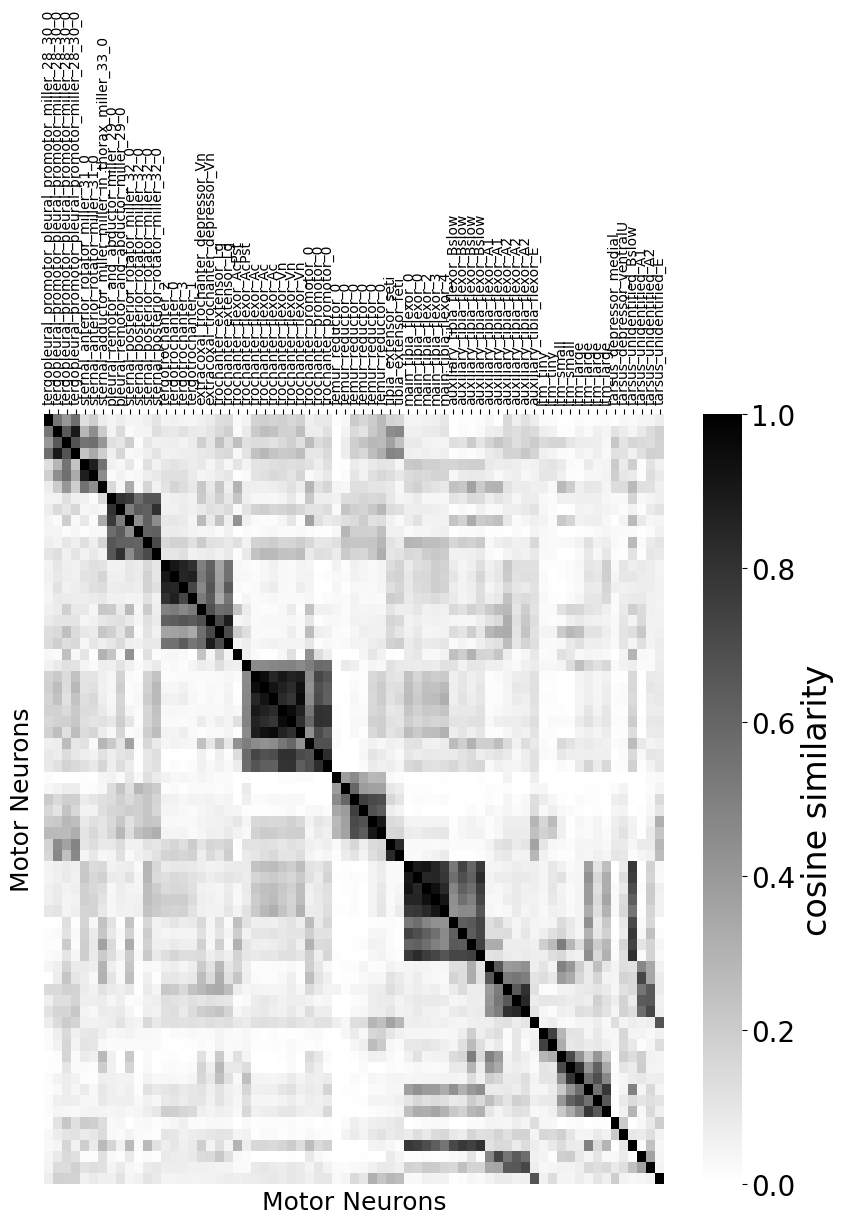

In [6]:
lbls = [ i + '_'+j for i,j in zip(pre_to_mn_df.columns.get_level_values('muscle'),pre_to_mn_df.columns.get_level_values('rank').astype('str'))]

sim_mat = cosine_similarity(pre_to_mn_df.to_numpy().transpose())
fig = plt.figure(1, figsize = [10,10])
ax = sns.heatmap(sim_mat, xticklabels=lbls, yticklabels=[],cmap=cos_cmap) # plt.get_cmap('Greys'))
ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'cosine similarity', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
plt.ylabel('Motor Neurons', fontsize =18)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.show()

### ta_assigned_pools_asterix (use this one)

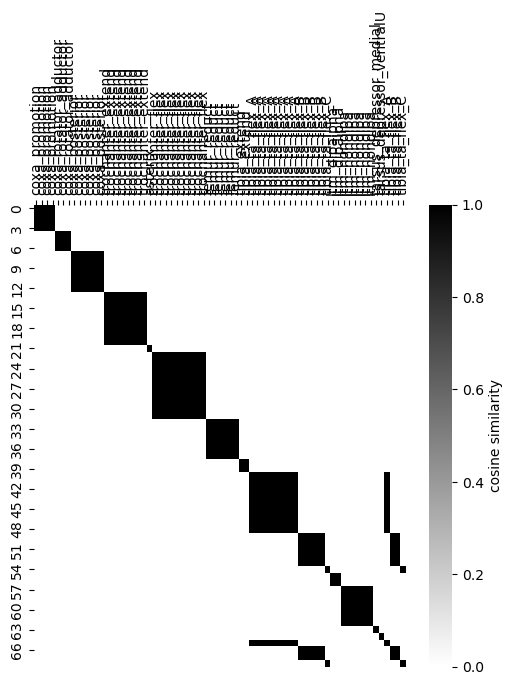

0.9973682961556716
0.643923737681696


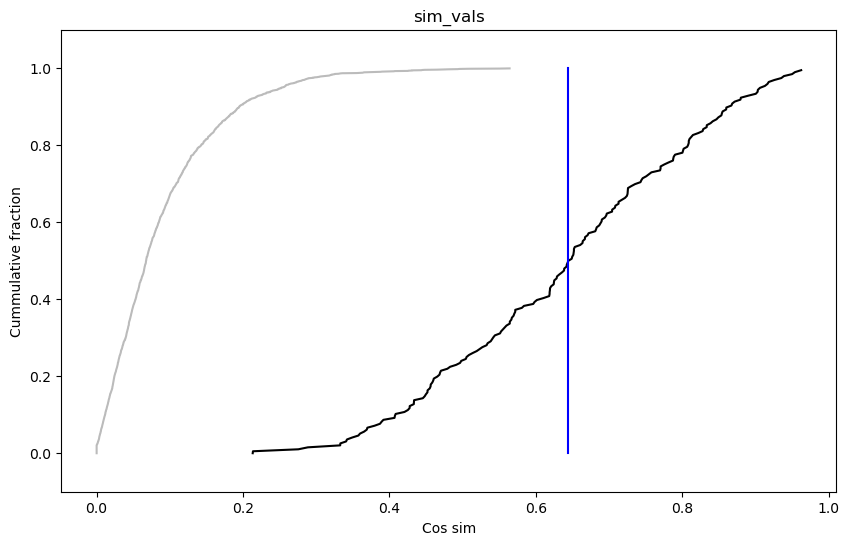

In [7]:
mn_mi_df = pre_to_mn_df.columns.to_frame()
mn_mi_df

# Ha! for this, put the tarsus neurons in the right pools
muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_pools_coxa_ab()

for key in pool_keys:
    mn_tup = muscle_tuple_dict[key]
    mn_mi_df.loc[mn_tup,'preferred_pool'] = key

pool_keys.append('asterix')
mn_mi_df.loc[mn_mi_df.segID==mn_mi_df.iloc[21].segID,'preferred_pool'] = 'asterix'

mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.astype("category")
mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys)
mn_mi_df.iloc[21]


sim_mat = cosine_similarity(pre_to_mn_df.to_numpy().transpose())

tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
motor_pool_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), False, dtype=bool)
i_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
j_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].preferred_pool==mn_mi_df.iloc[j,:].preferred_pool)
        i_index[i,j] = i
        j_index[i,j] = j

fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(motor_pool_mask, xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=cos_cmap)
clean_hmax(ax)
# fig = plt.figure(2, figsize = [6,6])
# ax = sns.heatmap(np.tril(motor_pool_mask,-1), xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=cos_cmap)


tril_mask = np.tril(tril_mask,-1)

pool_arr = mn_mi_df.preferred_pool.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))

sim_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }

sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
# # get rid of upper triangle
sim_compare_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]

cnt = 0
ks_val = {}
mwu_val = []
dprime_a = []

cnt=cnt+1
idx = 'sim_vals'

# def plot_shuf_cum(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None):
fig = plt.figure(cnt, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylim([-.1, 1.1])
# ax.set_xlim([.945, .96])
# ax.set_xlim([0, 1])
ax.set_ylabel('Cummulative fraction')
ax.set_xlabel('Cos sim')
ax.set_title(idx)

x_outofpool = sim_compare_df.loc[~sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_outofpool))).astype(float)/len(x_outofpool)
ax.plot(sorted(x_outofpool),y,color='#BBBBBB')

x_inpool = sim_compare_df.loc[sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_inpool))).astype(float)/len(x_inpool)
ax.plot(sorted(x_inpool),y,color='#000000')



ks_val = scipy.stats.kstest(x_inpool,x_outofpool)
mwu_out = scipy.stats.mannwhitneyu(x_inpool,x_outofpool)
mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))
dprime_a.append(np.abs(np.mean(x_inpool)-np.mean(x_outofpool))/np.sqrt((np.var(x_inpool)+np.var(x_outofpool))/2))

mwu_val_max = mwu_val[-1]
print(mwu_val_max)

x_inpool_median = x_inpool.median()
print(x_inpool_median)
ax.plot(x_inpool_median*np.array([1,1]),np.array([0,1]),color='#0000FF')

fig.savefig('./figpanels/cdf_sim_ta_assigned_pools_coxa_ab_asterix.svg',format='svg')

In [8]:
mwu_out

MannwhitneyuResult(statistic=420291.0, pvalue=6.312306539470767e-118)

# Compare distributions for local vs. etc

## Regress local vs. normal, vs. descending, etc.

In [9]:
mn_mi_df

side  \
side nerve   segment function muscle                                             rank     segID                     
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346487756866    L   
                                                                                          648518346491659326    L   
                                                                                          648518346517437482    L   
                                                                                          648518346479446972    L   
     Ventral thorax  swing    sternal_anterior_rotator_miller_31                 0        648518346479325585    L   
...                                                                                                           ...   
     Leg     tibia   flex     tarsus_depressor                                   ventralU 648518346486890393    L   
                     unknown  tarsus_unidentified                                Bslow    648518346480904925    L   
                                                                                 A1       648518346489767549    L   
                                                                                 A2       648518346495467855    L   
                                                                                 E        648518346511950704    L   

                                                                                                                nerve  \
side nerve   segment function muscle                                             rank     segID                         
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346487756866   Dorsal   
                                                                                          648518346491659326   Dorsal   
                                                                                          648518346517437482   Dorsal   
                                                                                          648518346479446972   Dorsal   
     Ventral thorax  swing    sternal_anterior_rotator_miller_31                 0        648518346479325585  Ventral   
...                                                                                                               ...   
     Leg     tibia   flex     tarsus_depressor                                   ventralU 648518346486890393      Leg   
                     unknown  tarsus_unidentified                                Bslow    648518346480904925      Leg   
                                                                                 A1       648518346489767549      Leg   
                                                                                 A2       648518346495467855      Leg   
                                                                                 E        648518346511950704      Leg   

                                                                                                             segment  \
side nerve   segment function muscle                                             rank     segID                        
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346487756866  thorax   
                                                                                          648518346491659326  thorax   
                                                                                          648518346517437482  thorax   
                                                                                          648518346479446972  thorax   
     Ventral thorax  swing    sternal_anterior_rotator_miller_31                 0        648518346479325585  thorax   
...                                                                                                              ...   
     Leg     tibia   flex     tarsus_depressor       

array(['coxa_promotion', 'coxa_promotion', 'coxa_promotion', ...,
       'tibia_ta_flex_C', 'tibia_ta_flex_C', 'tibia_ta_flex_C'],
      dtype=object)

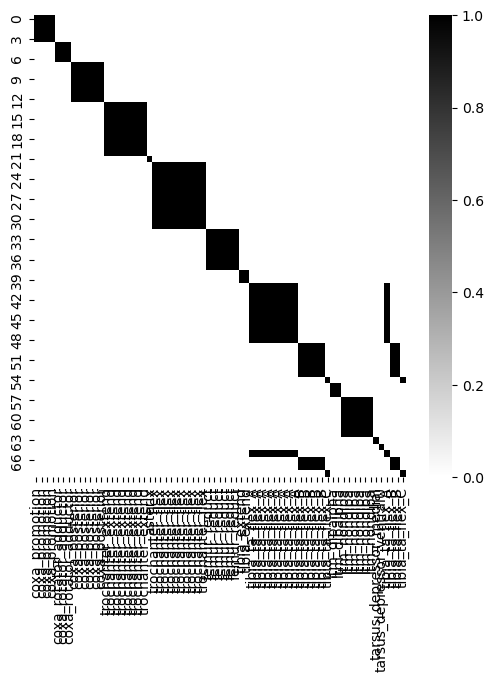

In [10]:
sim_mat_all = cosine_similarity(pre_to_mn_df.to_numpy().transpose())
sim_mat_local = cosine_similarity(pre_to_mn_df.loc['local',:].to_numpy().transpose())
sim_mat_desc = cosine_similarity(pre_to_mn_df.loc['descending',:].to_numpy().transpose())
sim_mat_inter = cosine_similarity(pre_to_mn_df.loc['intersegmental',:].to_numpy().transpose())
sim_mat_ascending = cosine_similarity(pre_to_mn_df.loc['ascending',:].to_numpy().transpose())
sim_mat_sensory = cosine_similarity(pre_to_mn_df.loc['sensory',:].to_numpy().transpose())

tril_mask = np.full((sim_mat_all.shape[0], sim_mat_all.shape[1]), True, dtype=bool)
motor_pool_mask = np.full((sim_mat_all.shape[0], sim_mat_all.shape[1]), False, dtype=bool)
i_index = np.full((sim_mat_all.shape[0], sim_mat_all.shape[1]), 0, dtype=int)
j_index = np.full((sim_mat_all.shape[0], sim_mat_all.shape[1]), 0, dtype=int)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].preferred_pool==mn_mi_df.iloc[j,:].preferred_pool)
        i_index[i,j] = i
        j_index[i,j] = j

fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(motor_pool_mask, xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=cos_cmap)

# fig = plt.figure(2, figsize = [6,6])
# ax = sns.heatmap(np.tril(motor_pool_mask,-1), xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=plt.get_cmap('Greys'))

tril_mask = np.tril(tril_mask,-1)

pool_arr = mn_mi_df.preferred_pool.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))
pool_arr.reshape(-1)

In [11]:
sim_dict = {
    'all_comps':sim_mat_all.reshape(-1),
    'local':sim_mat_local.reshape(-1),
    'desc':sim_mat_desc.reshape(-1),
    'inter':sim_mat_inter.reshape(-1),
    'asce':sim_mat_ascending.reshape(-1),
    'sense':sim_mat_sensory.reshape(-1),
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }


sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df
# # get rid of upper triangle
sim_compare_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]
sim_compare_df


,all_comps,local,desc,inter,asce,sense,pool,same_pool,lower_tri,i_index,j_index
69,0.540194,0.597239,0.233644,0.612735,0.621019,0.203653,coxa_promotion,True,True,1,0
138,0.407421,0.416860,0.030020,0.571002,0.604547,0.201660,coxa_promotion,True,True,2,0
139,0.651206,0.595143,0.181516,0.553743,0.948272,0.247782,coxa_promotion,True,True,2,1
207,0.566548,0.628860,0.120582,0.599235,0.602912,0.000000,coxa_promotion,True,True,3,0
208,0.903296,0.924201,0.657786,0.915427,0.985360,0.702878,coxa_promotion,True,True,3,1
...,...,...,...,...,...,...,...,...,...,...,...
4755,0.194803,0.194977,0.000000,0.406989,0.202448,0.000000,tibia_ta_flex_C,False,True,68,63
4756,0.048742,0.037554,0.050498,0.096120,0.205515,0.000000,tibia_ta_flex_C,False,True,68,64
4757,0.032949,0.031093,0.160726,0.000000,0.000000,0.000000,tibia_ta_flex_C,False,True,68,65
4758,0.039155,0.043749,0.000000,0.054694,0.000000,0.000000,tibia_ta_flex_C,False,True,68,66


# Rain cloud plots of within vs across pool cosine similarity

In [12]:
all(sim_compare_df.lower_tri)
sim_compare_df

,all_comps,local,desc,inter,asce,sense,pool,same_pool,lower_tri,i_index,j_index
69,0.540194,0.597239,0.233644,0.612735,0.621019,0.203653,coxa_promotion,True,True,1,0
138,0.407421,0.416860,0.030020,0.571002,0.604547,0.201660,coxa_promotion,True,True,2,0
139,0.651206,0.595143,0.181516,0.553743,0.948272,0.247782,coxa_promotion,True,True,2,1
207,0.566548,0.628860,0.120582,0.599235,0.602912,0.000000,coxa_promotion,True,True,3,0
208,0.903296,0.924201,0.657786,0.915427,0.985360,0.702878,coxa_promotion,True,True,3,1
...,...,...,...,...,...,...,...,...,...,...,...
4755,0.194803,0.194977,0.000000,0.406989,0.202448,0.000000,tibia_ta_flex_C,False,True,68,63
4756,0.048742,0.037554,0.050498,0.096120,0.205515,0.000000,tibia_ta_flex_C,False,True,68,64
4757,0.032949,0.031093,0.160726,0.000000,0.000000,0.000000,tibia_ta_flex_C,False,True,68,65
4758,0.039155,0.043749,0.000000,0.054694,0.000000,0.000000,tibia_ta_flex_C,False,True,68,66


In [13]:
(~sim_compare_df['same_pool']).sum()+sim_compare_df['same_pool'].sum()

2346

In [14]:
sim_compare_df

,all_comps,local,desc,inter,asce,sense,pool,same_pool,lower_tri,i_index,j_index
69,0.540194,0.597239,0.233644,0.612735,0.621019,0.203653,coxa_promotion,True,True,1,0
138,0.407421,0.416860,0.030020,0.571002,0.604547,0.201660,coxa_promotion,True,True,2,0
139,0.651206,0.595143,0.181516,0.553743,0.948272,0.247782,coxa_promotion,True,True,2,1
207,0.566548,0.628860,0.120582,0.599235,0.602912,0.000000,coxa_promotion,True,True,3,0
208,0.903296,0.924201,0.657786,0.915427,0.985360,0.702878,coxa_promotion,True,True,3,1
...,...,...,...,...,...,...,...,...,...,...,...
4755,0.194803,0.194977,0.000000,0.406989,0.202448,0.000000,tibia_ta_flex_C,False,True,68,63
4756,0.048742,0.037554,0.050498,0.096120,0.205515,0.000000,tibia_ta_flex_C,False,True,68,64
4757,0.032949,0.031093,0.160726,0.000000,0.000000,0.000000,tibia_ta_flex_C,False,True,68,65
4758,0.039155,0.043749,0.000000,0.054694,0.000000,0.000000,tibia_ta_flex_C,False,True,68,66


c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

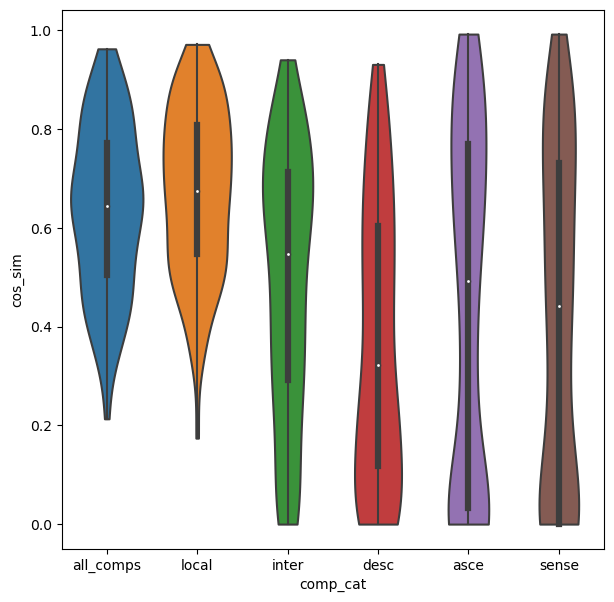

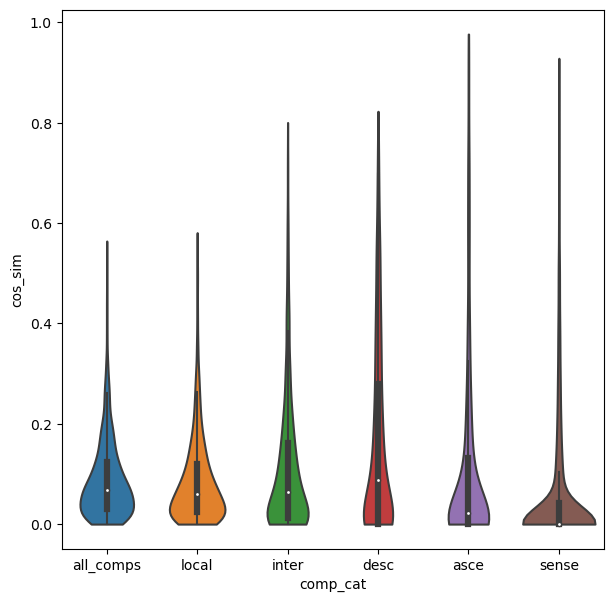

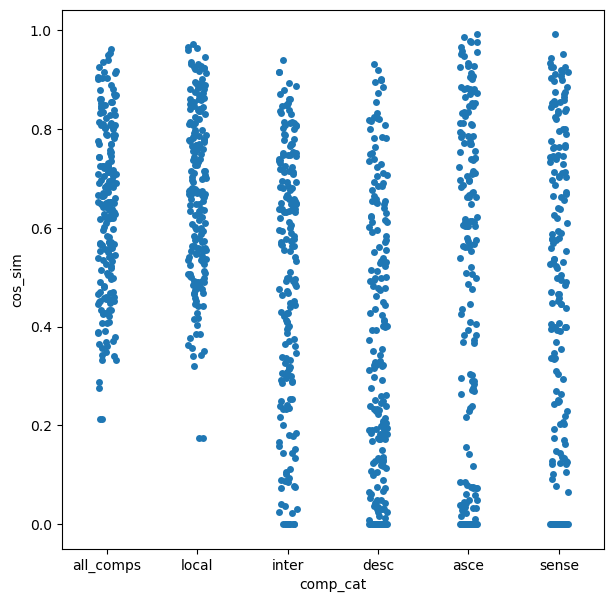

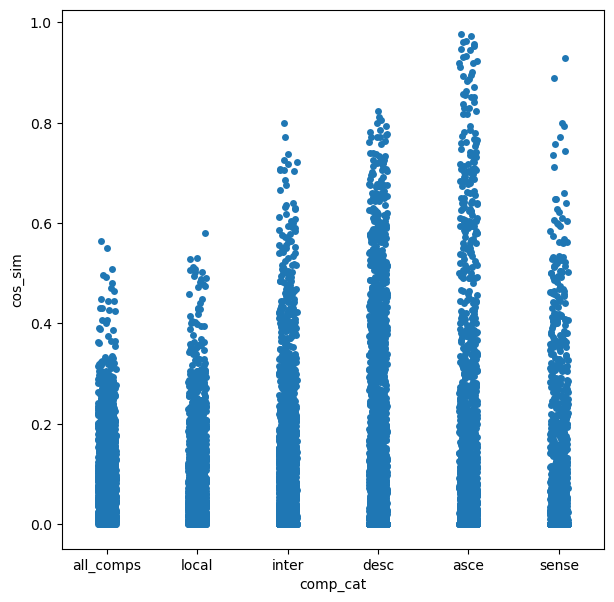

In [15]:
# sim_same_pool = sim_compare_df.loc[sim_compare_df.same_pool,:]
sim_same_pool_stacked = sim_compare_df.loc[:,['all_comps','pool','same_pool','lower_tri']]
sim_same_pool_stacked['comp_cat'] = 'all_comps'
sim_same_pool_stacked = sim_same_pool_stacked.rename({'all_comps':'cos_sim'},axis='columns')

block = sim_compare_df.loc[:,['local','pool','same_pool','lower_tri']]
block['comp_cat'] = 'local'
block = block.rename({'local':'cos_sim'},axis='columns')

sim_same_pool_stacked = pd.concat([sim_same_pool_stacked,block])
sim_same_pool_stacked

block = sim_compare_df.loc[:,['inter','pool','same_pool','lower_tri']]
block['comp_cat'] = 'inter'
block = block.rename({'inter':'cos_sim'},axis='columns')

sim_same_pool_stacked = pd.concat([sim_same_pool_stacked,block])
sim_same_pool_stacked

block = sim_compare_df.loc[:,['desc','pool','same_pool','lower_tri']]
block['comp_cat'] = 'desc'
block = block.rename({'desc':'cos_sim'},axis='columns')

sim_same_pool_stacked = pd.concat([sim_same_pool_stacked,block])

block = sim_compare_df.loc[:,['asce','pool','same_pool','lower_tri']]
block['comp_cat'] = 'asce'
block = block.rename({'asce':'cos_sim'},axis='columns')

sim_same_pool_stacked = pd.concat([sim_same_pool_stacked,block])

block = sim_compare_df.loc[:,['sense','pool','same_pool','lower_tri']]
block['comp_cat'] = 'sense'
block = block.rename({'sense':'cos_sim'},axis='columns')

sim_same_pool_stacked = pd.concat([sim_same_pool_stacked,block])
sim_same_pool_stacked

# ax.set_ylim([0,1.1])
# f.savefig('./figpanels/cosine_sim_violin_all_comps.svg',format='svg')

# ax.set_ylim([0,1.1])

# f.savefig('./figpanels/pool_pref_by_NT_violin.svg',format='svg')

f, ax = plt.subplots(figsize=(7, 7))
sns.violinplot(data=sim_same_pool_stacked.loc[sim_same_pool_stacked.same_pool],x='comp_cat',y='cos_sim',orient='vertical',scale='area', cut=0, ax=ax)

f.savefig('./figpanels/cosine_sim_violin_same_pool.svg',format='svg')

f, ax = plt.subplots(figsize=(7, 7))
sns.violinplot(data=sim_same_pool_stacked.loc[~sim_same_pool_stacked.same_pool,:],x='comp_cat',y='cos_sim',orient='vertical',scale='area', cut=0, ax=ax,bw=.25)

f.savefig('./figpanels/cosine_sim_violin_different_pools.svg',format='svg')


f, ax = plt.subplots(figsize=(7, 7))
sns.stripplot(data=sim_same_pool_stacked.loc[sim_same_pool_stacked.same_pool],x='comp_cat',y='cos_sim',ax=ax)

f.savefig('./figpanels/cosine_sim_rain_same_pool.svg',format='svg')

f, ax = plt.subplots(figsize=(7, 7))
sns.stripplot(data=sim_same_pool_stacked.loc[~sim_same_pool_stacked.same_pool,:],x='comp_cat',y='cos_sim',ax=ax)

f.savefig('./figpanels/cosine_sim_rain_different_pools.svg',format='svg')

In [16]:
sim_w_pool = sim_compare_df.loc[sim_compare_df['same_pool'],:]
sim_w_pool.melt(value_vars=['all_comps','local','desc','inter'])

,variable,value
0,all_comps,0.540194
1,all_comps,0.407421
2,all_comps,0.651206
3,all_comps,0.566548
4,all_comps,0.903296
...,...,...
779,inter,0.777897
780,inter,0.252746
781,inter,0.693625
782,inter,0.111971


In [17]:
import scipy
scipy.stats.kruskal(sim_w_pool['all_comps'],
                    sim_w_pool['local'],
                    sim_w_pool['desc'],
                    sim_w_pool['inter'],)
# scipy.stats.kruskal(ratiodf.iloc[:,0],ratiodf.iloc[:,1],ratiodf.iloc[:,2],ratiodf.iloc[:,3],ratiodf.iloc[:,4],ratiodf.iloc[:,5],ratiodf.iloc[:,6],ratiodf.iloc[:,7],ratiodf.iloc[:,8])

KruskalResult(statistic=147.77064235008916, pvalue=7.973639041120559e-32)

In [18]:
import scikit_posthocs 

scikit_posthocs.posthoc_conover(sim_w_pool.melt(value_vars=['all_comps','local','desc','inter']),val_col= 'value',group_col='variable',p_adjust='holm')


,all_comps,desc,inter,local
all_comps,1.000000e+00,1.421109e-22,1.470936e-07,6.392638e-02
desc,1.421109e-22,1.000000e+00,4.713581e-06,2.549043e-30
inter,1.470936e-07,4.713581e-06,1.000000e+00,1.812885e-12
local,6.392638e-02,2.549043e-30,1.812885e-12,1.000000e+00


# Cumulative fraction within vs. across pool comps

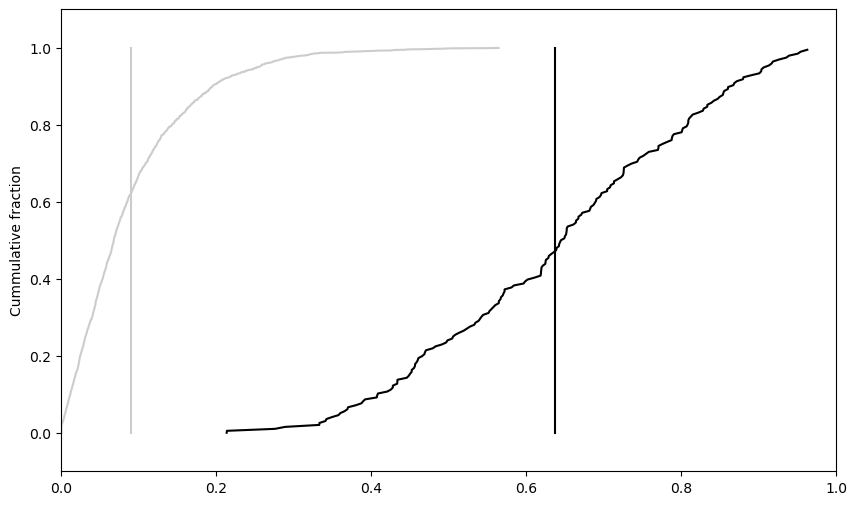

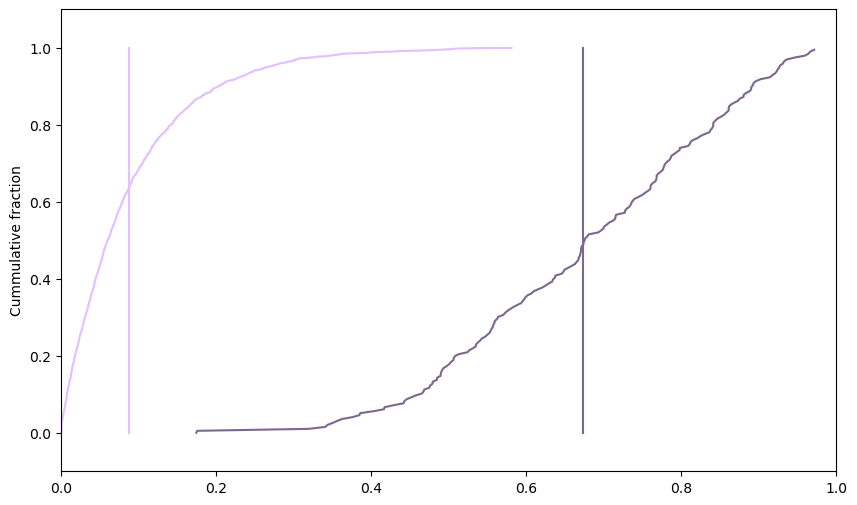

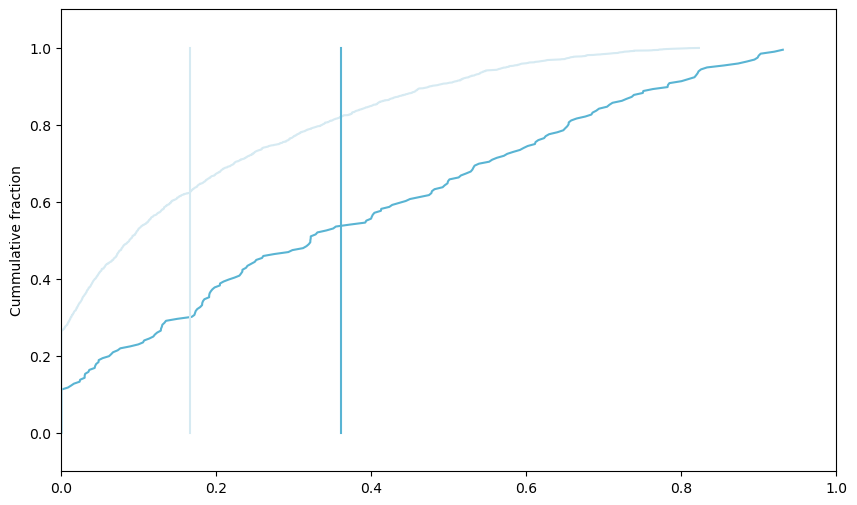

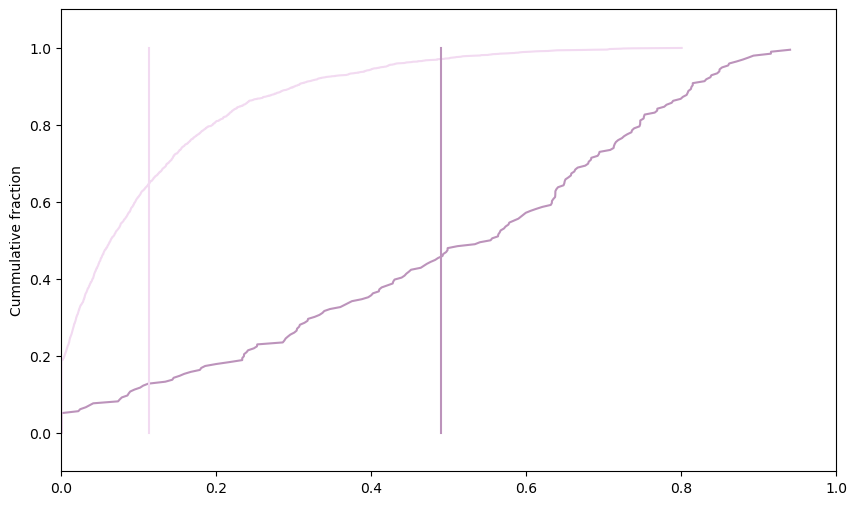

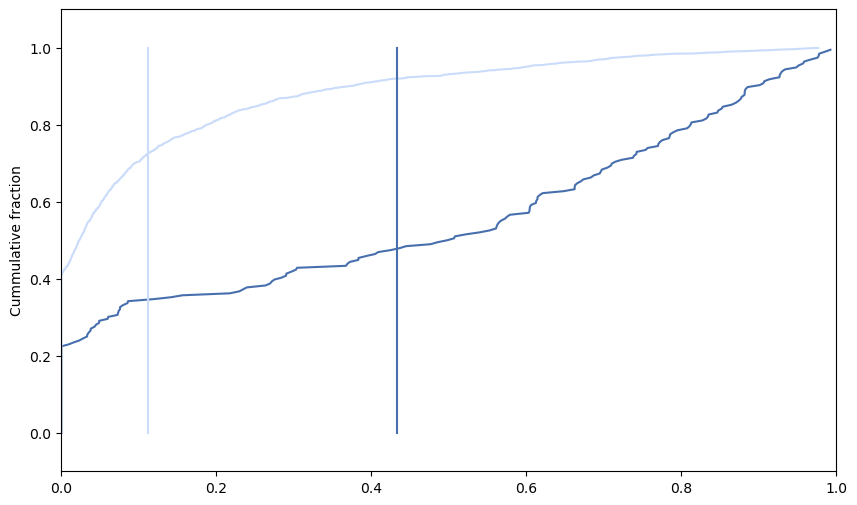

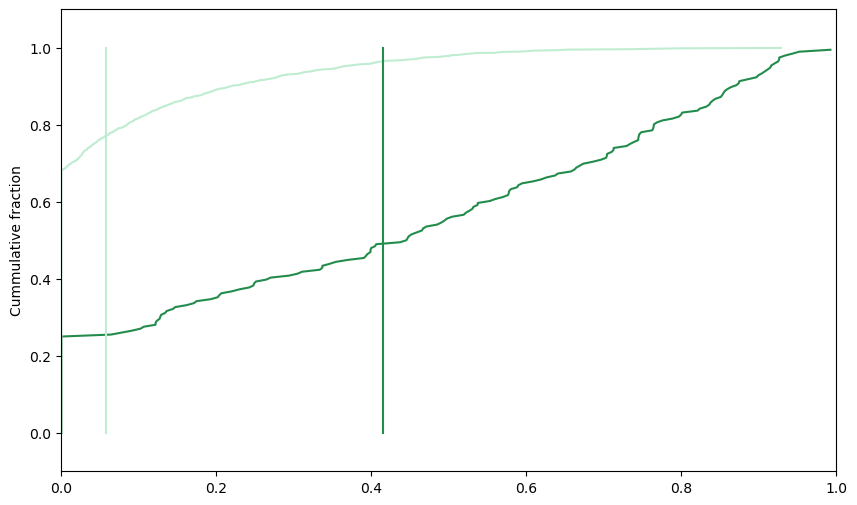

In [19]:
mwu_df = sim_compare_df.iloc[0:4,:].copy()
mwu_df = mwu_df[['all_comps','local','desc','inter','asce','sense']]
mwu_df['idx'] = ['statistic','pvalue','comps','auc']
mwu_df = mwu_df.set_index('idx')
mwu_df

clr_dict = {'all_comps':'#000000',
            'local':'#7d688d',
            'desc':'#59b4d3',
            'inter':'#bc93bb',
            'asce':'#476fad',
            'sense':'#238c4d',}
clr2_dict = {'all_comps':'#cccccc',
            'local':'#e2c0ff',
            'desc':'#d6eaf2',
            'inter':'#f2daf1',
            'asce':'#cadcf9',
            'sense':'#c0edd2',}

ax = None
fig_cnt = 0
for col in mwu_df.columns:
# for col in ['all_comps','local']:
    y_in = sim_compare_df.loc[sim_compare_df['same_pool'],col]
    y_out = sim_compare_df.loc[~sim_compare_df['same_pool'],col]
    fig_cnt = fig_cnt+1
    ax = plot_inout_cum(y_in,
                x_outpool_unsorted=y_out, 
                color=clr_dict[col],
                color_out=clr2_dict[col],
                fignum=fig_cnt,
                fn = 'invout_cdf_{}'.format(col))
    
    mwu_out = scipy.stats.mannwhitneyu(y_in,y_out)
    mwu_df.loc['statistic',col] = mwu_out.statistic
    mwu_df.loc['pvalue',col] = mwu_out.pvalue
    mwu_df.loc['comps',col] = (len(y_in)*len(y_out))
    mwu_df.loc['auc',col] = mwu_out.statistic / (len(y_in)*len(y_out))
    mwu_df.loc['median_in',col] = y_in.median()
    mwu_df.loc['median_out',col] = y_out.median()
    mwu_df.loc['mean_in',col] = y_in.mean()
    mwu_df.loc['mean_out',col] = y_out.mean()


In [20]:
mwu_df_plt = mwu_df.loc[['auc','median_in','median_out','mean_in','mean_out'],['all_comps','local','inter','desc','asce','sense']]

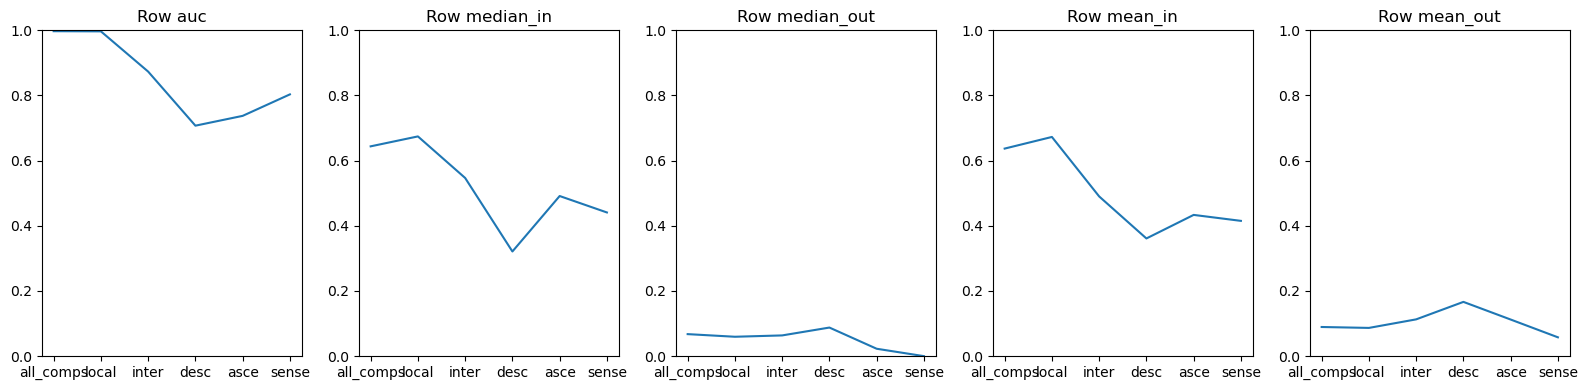

In [21]:
# Set up the subplots
fig, axs = plt.subplots(nrows=1, ncols=mwu_df_plt.shape[0], figsize=(2*mwu_df.shape[0],4))

# Plot each row in a separate subplot
for i, (row_name, data_row) in enumerate(mwu_df_plt.iterrows()):
    axs[i].plot(data_row.values)
    axs[i].set_xticks(range(len(data_row)))
    axs[i].set_xticklabels(data_row.index)
    axs[i].set_title(f'Row {row_name}')
    axs[i].set_ylim([0,1])

# Adjust layout for better visibility
plt.tight_layout()

# Show the plot
plt.show()

fig.savefig('./figpanels/cos_similarity_per_cell_class.svg',format='svg')

In [31]:
mwu_df_plt

,all_comps,local,inter,desc,asce,sense
idx,,,,,,
auc,0.997368,0.996837,0.873338,0.707367,0.737470,0.803412
median_in,0.643924,0.674413,0.546859,0.321201,0.491439,0.440993
median_out,0.067560,0.059493,0.063590,0.087720,0.022679,0.000000
mean_in,0.637043,0.672746,0.490205,0.361213,0.433485,0.415201
mean_out,0.089440,0.086640,0.112869,0.166512,0.112348,0.057776


In [22]:
mwu_in_comp_df = pd.DataFrame(columns=mwu_df.columns,index = mwu_df.columns)

In [23]:
for col in range(0,5,1):
    for row in range(col+1,6,1):
        cl = mwu_in_comp_df.iloc[[row],[col]].columns.to_list()[-1]
        rw = mwu_in_comp_df.iloc[[row],[col]].index.to_list()[-1]
        y_in = sim_compare_df.loc[sim_compare_df['same_pool'],cl]
        y_out = sim_compare_df.loc[sim_compare_df['same_pool'],rw]

        mwu_out = scipy.stats.mannwhitneyu(y_in,y_out)
        mwu_in_comp_df.iloc[row,col] = mwu_out.pvalue


In [24]:
mwu_in_comp_df.to_numpy()

array([[nan, nan, nan, nan, nan, nan],
       [0.03692095223980367, nan, nan, nan, nan, nan],
       [2.4737454646057725e-21, 1.3049055969913472e-25, nan, nan, nan,
        nan],
       [2.519475205256738e-07, 2.129794402835224e-11,
        5.786582395070728e-06, nan, nan, nan],
       [9.0124631582907e-07, 2.7157969739876806e-09, 0.10415058158316078,
        0.139502845971257, nan, nan],
       [3.8899246463321564e-10, 1.354360825835382e-13,
        0.24438476081756733, 0.02240011707324648, 0.470877613915166, nan]],
      dtype=object)

c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

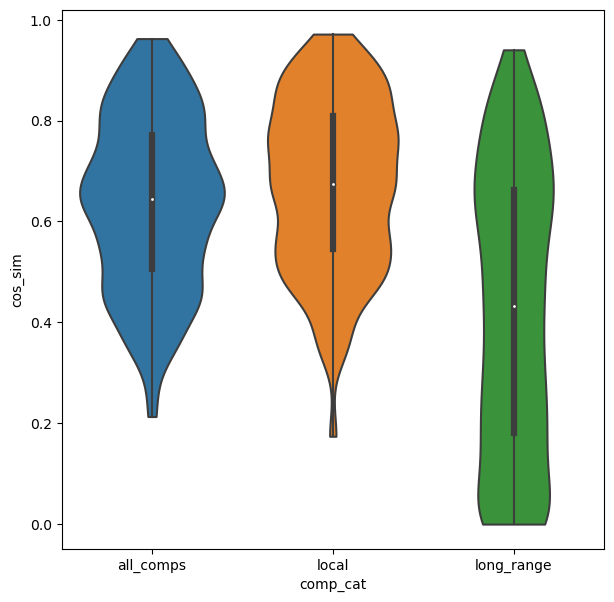

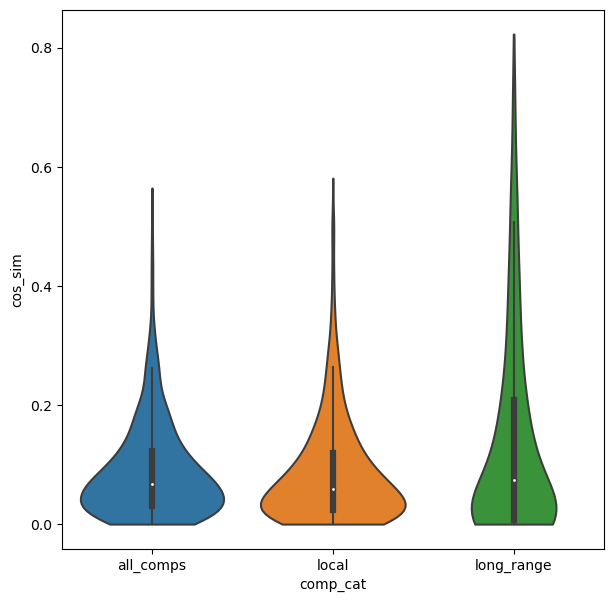

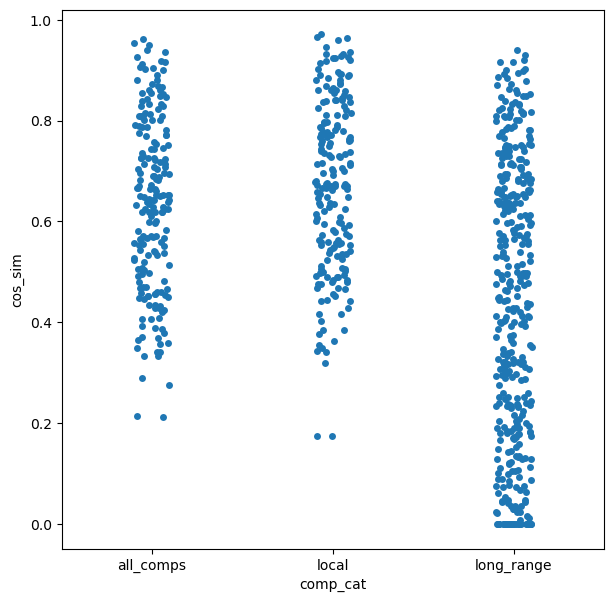

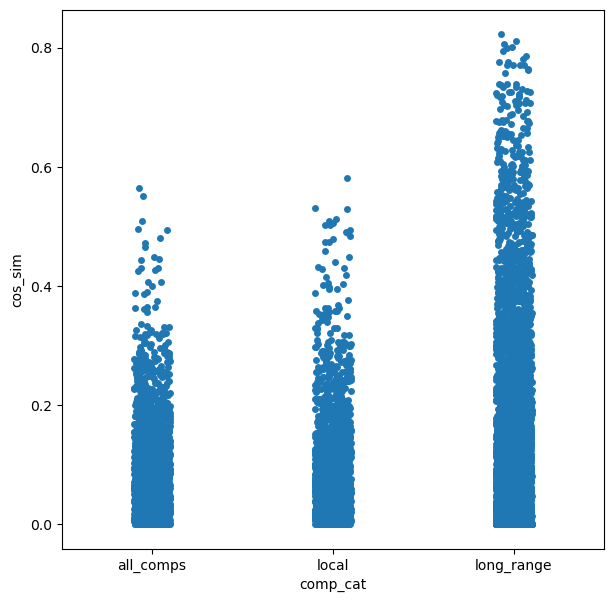

In [25]:
# f, ax = plt.subplots(figsize=(7, 7))
# # seaborn.violinplot(data=pprst, *, x=None, y=None, hue=None, order=None, hue_order=None, bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100, width=0.8, inner='box', split=False, dodge=True, orient=None, linewidth=None, color=None, palette=None, saturation=0.75, ax=None, **kwargs)
# seaborn.violinplot(data=pprst,x='NT',y='pref_perc', orient='vertical',scale='count', cut=0, ax=ax)
# # sns.stripplot(data=pprst,x='NT',y='pref_perc',hue='syn_total',ax=ax)


# f, ax = plt.subplots(figsize=(7, 7))
# sns.violinplot(data=sim_compare_df,x='same_pool',y='all_comps',orient='vertical',scale='area', cut=0, ax=ax)

# sim_same_pool = sim_compare_df.loc[sim_compare_df.same_pool,:]
sim_same_pool_stacked = sim_compare_df.loc[:,['all_comps','pool','same_pool','lower_tri']]
sim_same_pool_stacked['comp_cat'] = 'all_comps'
sim_same_pool_stacked = sim_same_pool_stacked.rename({'all_comps':'cos_sim'},axis='columns')

block = sim_compare_df.loc[:,['local','pool','same_pool','lower_tri']]
block['comp_cat'] = 'local'
block = block.rename({'local':'cos_sim'},axis='columns')

sim_same_pool_stacked = pd.concat([sim_same_pool_stacked,block])
sim_same_pool_stacked

block = sim_compare_df.loc[:,['inter','pool','same_pool','lower_tri']]
block['comp_cat'] = 'long_range'
block = block.rename({'inter':'cos_sim'},axis='columns')

sim_same_pool_stacked = pd.concat([sim_same_pool_stacked,block])
sim_same_pool_stacked

block = sim_compare_df.loc[:,['desc','pool','same_pool','lower_tri']]
block['comp_cat'] = 'long_range'
block = block.rename({'desc':'cos_sim'},axis='columns')

sim_same_pool_stacked = pd.concat([sim_same_pool_stacked,block])
sim_same_pool_stacked

# ax.set_ylim([0,1.1])
# f.savefig('./figpanels/cosine_sim_violin_all_comps.svg',format='svg')

# ax.set_ylim([0,1.1])

# f.savefig('./figpanels/pool_pref_by_NT_violin.svg',format='svg')

f, ax = plt.subplots(figsize=(7, 7))
sns.violinplot(data=sim_same_pool_stacked.loc[sim_same_pool_stacked.same_pool],x='comp_cat',y='cos_sim',orient='vertical',scale='area', cut=0, ax=ax,bw=.25)

f.savefig('./figpanels/cosine_sim_violin_same_pool_long.svg',format='svg')

f, ax = plt.subplots(figsize=(7, 7))
sns.violinplot(data=sim_same_pool_stacked.loc[~sim_same_pool_stacked.same_pool,:],x='comp_cat',y='cos_sim',orient='vertical',scale='area', cut=0, ax=ax, bw=.3)

f.savefig('./figpanels/cosine_sim_violin_different_pools_long.svg',format='svg')


f, ax = plt.subplots(figsize=(7, 7))
sns.stripplot(data=sim_same_pool_stacked.loc[sim_same_pool_stacked.same_pool],x='comp_cat',y='cos_sim',ax=ax)

f.savefig('./figpanels/cosine_sim_rain_same_pool_long.svg',format='svg')

f, ax = plt.subplots(figsize=(7, 7))
sns.stripplot(data=sim_same_pool_stacked.loc[~sim_same_pool_stacked.same_pool,:],x='comp_cat',y='cos_sim',ax=ax)

f.savefig('./figpanels/cosine_sim_rain_different_pools_long.svg',format='svg')

In [26]:
# fig, axes = plt.subplots()

# # Seaborn violin plot
# sns.violinplot(data=a, color="#af52f4", inner=None, linewidth=0, saturation=0.5)

# # Normal boxplot has full range, same in Seaborn boxplot
# axes.boxplot(a, whis='range', positions=np.array([0]),
#             showcaps=False,widths=0.06, patch_artist=True,
#             boxprops=dict(color="indigo", facecolor="indigo"),
#             whiskerprops=dict(color="indigo", linewidth=2),
#             medianprops=dict(color="w", linewidth=2 ))

# axes.set_xlim(-1,1)
# plt.show()

In [32]:
sim_compare_df

,all_comps,local,desc,inter,asce,sense,pool,same_pool,lower_tri,i_index,j_index
69,0.540194,0.597239,0.233644,0.612735,0.621019,0.203653,coxa_promotion,True,True,1,0
138,0.407421,0.416860,0.030020,0.571002,0.604547,0.201660,coxa_promotion,True,True,2,0
139,0.651206,0.595143,0.181516,0.553743,0.948272,0.247782,coxa_promotion,True,True,2,1
207,0.566548,0.628860,0.120582,0.599235,0.602912,0.000000,coxa_promotion,True,True,3,0
208,0.903296,0.924201,0.657786,0.915427,0.985360,0.702878,coxa_promotion,True,True,3,1
...,...,...,...,...,...,...,...,...,...,...,...
4755,0.194803,0.194977,0.000000,0.406989,0.202448,0.000000,tibia_ta_flex_C,False,True,68,63
4756,0.048742,0.037554,0.050498,0.096120,0.205515,0.000000,tibia_ta_flex_C,False,True,68,64
4757,0.032949,0.031093,0.160726,0.000000,0.000000,0.000000,tibia_ta_flex_C,False,True,68,65
4758,0.039155,0.043749,0.000000,0.054694,0.000000,0.000000,tibia_ta_flex_C,False,True,68,66


# Stats

In [28]:
# Simple version, just mean and std of same pool, not same pool
x = sim_compare_df.loc[sim_compare_df.same_pool,'local'].mean()
y = sim_compare_df.loc[sim_compare_df.same_pool,'inter'].mean()

x2 = sim_compare_df.loc[~sim_compare_df.same_pool,'local'].mean()
y2 = sim_compare_df.loc[~sim_compare_df.same_pool,'inter'].mean()


In [37]:
x = sim_compare_df.loc[sim_compare_df.same_pool,'local']
y = sim_compare_df.loc[sim_compare_df.same_pool,'all_comps']

mwu_out = scipy.stats.mannwhitneyu(x,y)
mwu_out.statistic / (len(x)*len(y))
print(mwu_out)

print(sim_compare_df.loc[sim_compare_df.same_pool,'local'].median())
print(sim_compare_df.loc[sim_compare_df.same_pool,'all_comps'].median())

print(sim_compare_df.loc[sim_compare_df.same_pool,'local'].shape)

MannwhitneyuResult(statistic=21549.0, pvalue=0.03692095223980367)
0.6744125176580762
0.643923737681696
(196,)


In [29]:
import scipy

scipy.stats.ttest_rel(sim_compare_df.loc[sim_compare_df.same_pool,'local'],sim_compare_df.loc[sim_compare_df.same_pool,'all_comps'],alternative='two-sided',axis=0)

TtestResult(statistic=14.567128690176187, pvalue=5.2225413130863204e-33, df=195)

In [30]:
sim_compare_df.loc[~sim_compare_df.same_pool,'local'].to_numpy()

array([0.11092315, 0.15788078, 0.50290594, ..., 0.03109305, 0.04374892,
       0.04172394])